In [9]:
#### Require python 3.10+
!python --version

Python 3.11.8


In [7]:
%conda install -c conda-forge ipywidgets

Channels:
 - conda-forge
 - defaults
Platform: linux-aarch64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install --no-cache-dir opensearch-py python-dotenv boto3 tqdm h5py matplotlib ipywidgets jedi ipython matplotlib 

DEPRECATION: Loading egg at /home/ec2-user/miniconda3/envs/faiss-cpu/lib/python3.11/site-packages/faiss-1.8.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [10]:
# For autocomplete use shift+tab
%config IPCompleter.greedy=True

In [1]:
# Download the sift-128 dataset
!curl -o sift-128-euclidean.hdf5 -L http://ann-benchmarks.com/sift-128-euclidean.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   167  100   167    0     0   4578      0 --:--:-- --:--:-- --:--:--  4638


100  500M  100  500M    0     0   115M      0  0:00:04  0:00:04 --:--:--  117M


In [12]:
# Read Data set
import numpy as np
import h5py

dataset = h5py.File('sift-128-euclidean.hdf5', "r")
X_TRAIN = np.array(dataset["train"])
X_TEST = np.array(dataset["test"])
X_NEIGHBORS = np.array(dataset["neighbors"])
dimension = int(dataset.attrs["dimension"]) if "dimension" in dataset.attrs else len(X_TRAIN[0])

print(f"Ingest dataset size is : {len(X_TRAIN)}")
print(f"Queries dataset size is : {len(X_TEST)}")
print(f"dataset dimensions is : {dimension}")

Ingest dataset size is : 1000000
Queries dataset size is : 10000
dataset dimensions is : 128


In [2]:
from dotenv import load_dotenv
from opensearchpy import OpenSearch, RequestsHttpConnection
import os


res = load_dotenv("environment.txt")

OS_HOST = os.getenv('OS_HOST')
OS_HOST = "172.17.0.3"
OS_PORT = os.getenv('OS_PORT')
OS_PORT = "9200"
OS_USER = os.getenv('USER_NAME')
OS_PASSWORD = os.getenv('PASSWORD')
vector_index_name = os.getenv('VECTOR_INDEX_NAME', "test-vector")


client = OpenSearch(
    hosts = [{'host': OS_HOST, 'port': OS_PORT}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (OS_USER, OS_PASSWORD),
    use_ssl = False,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    timeout=6000,
    pool_maxsize = 20
)

client.info()


import time


print(f"vector index name from env is : {vector_index_name}")

vector index name from env is : test_vector


In [14]:
def create_index(index_name):
    index_mappings = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0,
            "index": {
                "knn": True,
                "knn.algo_param.ef_search": 128, # Adjust to improve precision. Higher improves recall & precsion but increases latency. Lower degrades recall & precision but improves latency.
                "refresh_interval" : "-1", # This is to ensure that we are creating mininal number of segments.
            },
        },
        "mappings": {
            "properties": {
                "vec": {
                    "type": "knn_vector",
                    "dimension": dimension,
                    "index": "true",
                    "method": {
                        "name": "hnsw",
                        "space_type": "l2", # l2 for SIFT, cosinesimil for typical
                        "engine": "faiss",
                        "parameters": {
                            "ef_construction": 128
                        }
                    }
                }
            }
        }
    }

    if client.indices.exists(index=index_name):
        response = client.indices.delete(index=index_name)
        print(f"Deleting the index. Response : {response}")

    response = client.indices.create(index=index_name, body=index_mappings)
    print(f"Creating the index. Response : {response}")



In [15]:
# ingest data in the index
from tqdm.notebook import tqdm
from opensearchpy.helpers import bulk
import time


create_index(vector_index_name)

bulk_size = 1000
def dataGen():
    for i, vec in enumerate(X_TRAIN):
        yield { "_index": vector_index_name, "_id": str(i), "vec": vec.tolist() }

settings = {
    "persistent": {
        "knn.vector_streaming_memory.limit": "1mb"
    }
}
client.cluster.put_settings(body=settings)

data_to_ingest = []
total_time_to_ingest = 0.
ingest_latency = []
mem_usage = []
for data in tqdm(dataGen(), total=len(X_TRAIN)):
    if len(data_to_ingest) == bulk_size:
        start = time.time()
        (res, errors) = bulk(client, data_to_ingest)
        end = time.time()
        total_time_to_ingest += (end-start)
        ingest_latency.append(end-start)
        if len(errors) != 0:
            print(errors)
            data_to_ingest = []
            StopIteration
        else:
            data_to_ingest = []

    if len(data_to_ingest) < bulk_size:
        data_to_ingest.append(data)
    
    #print(client.cluster.health())
    

if len(data_to_ingest) != 0:
    start = time.time()
    (_, errors) = bulk(client, data_to_ingest)
    mem_usage += client.cluster.health(index=[vector_index_name])
    end = time.time()
    total_time_to_ingest += (end-start)
    if len(errors) != 0:
        print(errors)
    else:
        data_to_ingest = []

print(f"Ingestion completed. Total time to ingest = {total_time_to_ingest} seconds, average time per document: {total_time_to_ingest/(len(X_TRAIN))}")
print(mem_usage)

Creating the index. Response : {'acknowledged': True, 'shards_acknowledged': True, 'index': 'test_vector'}


/home/ec2-user/miniconda3/envs/faiss-cpu/lib/python3.11/site-packages/opensearchpy/connection/base.py:179: OpenSearchWarning: Parameter [index] has no effect on type [knn_vector] and will be removed in future
  warnings.warn(message, category=OpenSearchWarning)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Ingestion completed. Total time to ingest = 917.3834865093231 seconds, average time per document: 0.0009173834865093231
['cluster_name', 'status', 'timed_out', 'number_of_nodes', 'number_of_data_nodes', 'discovered_master', 'discovered_cluster_manager', 'active_primary_shards', 'active_shards', 'relocating_shards', 'initializing_shards', 'unassigned_shards', 'delayed_unassigned_shards', 'number_of_pending_tasks', 'number_of_in_flight_fetch', 'task_max_waiting_in_queue_millis', 'active_shards_percent_as_number']


In [16]:
print(client.cat.indices(index=vector_index_name, params={'format': 'csv', 'v': 'true'}))

health status index       uuid                   pri rep docs.count docs.deleted store.size pri.store.size
green  open   test_vector 612i5XSARaWOsN4tWAg39w   1   0     840500            0      1.3gb          1.3gb



In [17]:
# Refresh the index as we set the refresh interval to -1
client.indices.refresh(index=vector_index_name)


client.indices.forcemerge(index=vector_index_name, max_num_segments=1)

client.indices.refresh(index=vector_index_name)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

In [18]:
# Check index details, you should see 1M documents in the index.
print(client.cat.indices(index=vector_index_name))

print("Segments Info After refresh...")

segments = client.cat.segments(vector_index_name, params={"format": "json"})

print(f"Total segments are: {len(segments)}")

print(f"Printing Segment info : \n{client.cat.segments(index=vector_index_name, params={'format': 'csv', 'v': 'true'})}")


green open test_vector 612i5XSARaWOsN4tWAg39w 1 0 1000000 0 2.5gb 2.5gb

Segments Info After refresh...
Total segments are: 1
Printing Segment info : 
index       shard prirep ip         segment generation docs.count docs.deleted  size size.memory committed searchable version compound
test_vector 0     p      172.17.0.2 _9               9    1000000            0 1.4gb           0 true      true       9.12.0  false



In [19]:
# Uncomment the below code to optimize the search latency
# Running the warmup api to load the graphs in the memory.
# Read more ways to tune the cluster here: https://opensearch.org/docs/latest/search-plugins/knn/performance-tuning/

#client.transport.perform_request('GET', f'/_plugins/_knn/warmup/{vector_index_name}', )

#print("--- Warmuped up the Cluster----")

client.indices.get_mapping(index='test_vector')

{'test_vector': {'mappings': {'properties': {'vec': {'type': 'knn_vector',
     'dimension': 128,
     'method': {'engine': 'faiss',
      'space_type': 'l2',
      'name': 'hnsw',
      'parameters': {'ef_construction': 128}}}}}}}

In [4]:
# Setup for Search
import numpy as np
from tqdm.notebook import tqdm

# search in the index
def searchQueryGen(input_array=X_TEST, k=100):
    for i, vec in enumerate(input_array):
        yield {
            "_source": False, # Don't get the source as this impacts latency
            "size": k,
            "query": {
                "knn": {
                    "vec": {
                        "vector": vec.tolist(),
                        "k": k
                    }
                }
            }
        }


neighbors_lists = []
search_latency = []
took_time = []
k = 10
for query in tqdm(searchQueryGen(input_array=X_TEST, k=k), total=len(X_TEST)):
    start = time.time()
    search_response = client.search(body=query, index=vector_index_name, _source=False, docvalue_fields=["_id"], stored_fields="_none_")
    end = time.time()
    search_latency.append(end - start)
    took_time.append(search_response["took"])
    search_hits = search_response['hits']['hits']
    search_neighbors = [int(hit["fields"]["_id"][0]) for hit in search_hits]
    neighbors_lists.append(search_neighbors)

print("Calculating Recall ...")
query_number:int = 0
recall:float = 0.
for actual_neighbors in tqdm(neighbors_lists):
    expected_neighbors = X_NEIGHBORS[query_number][0:k]
    counter = 0.0
    query_number = query_number + 1
    for element in actual_neighbors:
        if element in expected_neighbors:
            counter = counter + 1
    recall = recall + (counter/k)

recall = recall / len(X_TEST)

print(f'Recall @k{k} is : {recall}')


  0%|          | 0/10000 [00:00<?, ?it/s]

Calculating Recall ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Recall @k10 is : 0.9835999999999824


In [5]:
response = client.indices.delete(index=vector_index_name)
print(f"Deleting the index. Response : {response}")

Deleting the index. Response : {'acknowledged': True}


In [11]:
# Useful Metrics
print("========================== Search Metrics ===================================")
print("========================== Server Side Latency ===================================")
print(f"average took_time(ms): {np.average(took_time)}") 
print(f"p50 took_time(ms): {np.percentile(took_time, 50)}") 
print(f"p90 took_time(ms): {np.percentile(took_time, 90)}")
print(f"p99 took_time(ms): {np.percentile(took_time, 99)}")


print("========================== Client side latency ===================================")
print(f"\n\naverage Latency(ms): {np.average(search_latency) *1000}") 
print(f"p50 Latency(ms): {np.percentile(search_latency, 50) *1000}") 
print(f"p90 Latency(ms): {np.percentile(search_latency, 90) *1000}")
print(f"p99 Latency(ms): {np.percentile(search_latency, 99) *1000}")

print("========================== Recall Metrics===================================")
print(f'Recall @k{k} is : {recall}')

========================== Search Metrics ===================================
========================== Server Side Latency ===================================
average took_time(ms): 0.7049
p50 took_time(ms): 0.0
p90 took_time(ms): 1.0
p99 took_time(ms): 1.0
========================== Client side latency ===================================


average Latency(ms): 3.034060478210449
p50 Latency(ms): 2.7251243591308594
p90 Latency(ms): 3.291153907775879
p99 Latency(ms): 3.9790058135986337
========================== Recall Metrics===================================
Recall @k10 is : 0.9828899999999828


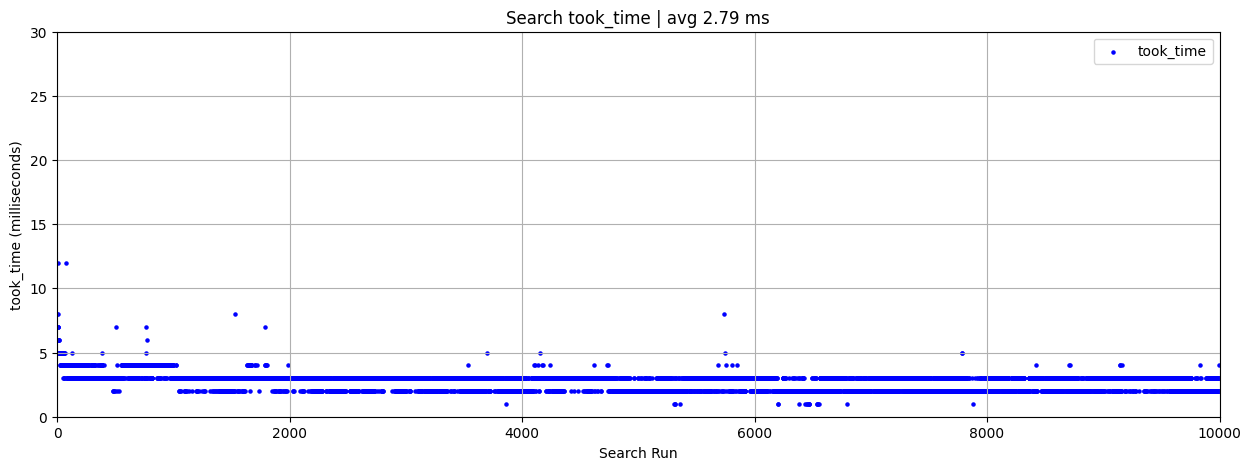

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "took_time": took_time
})

avg_latency = sum(took_time) / len(took_time)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['took_time'], label="took_time", color='blue', s=5)
plt.title(f"Search took_time | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(X_TEST)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 30) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("took_time (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

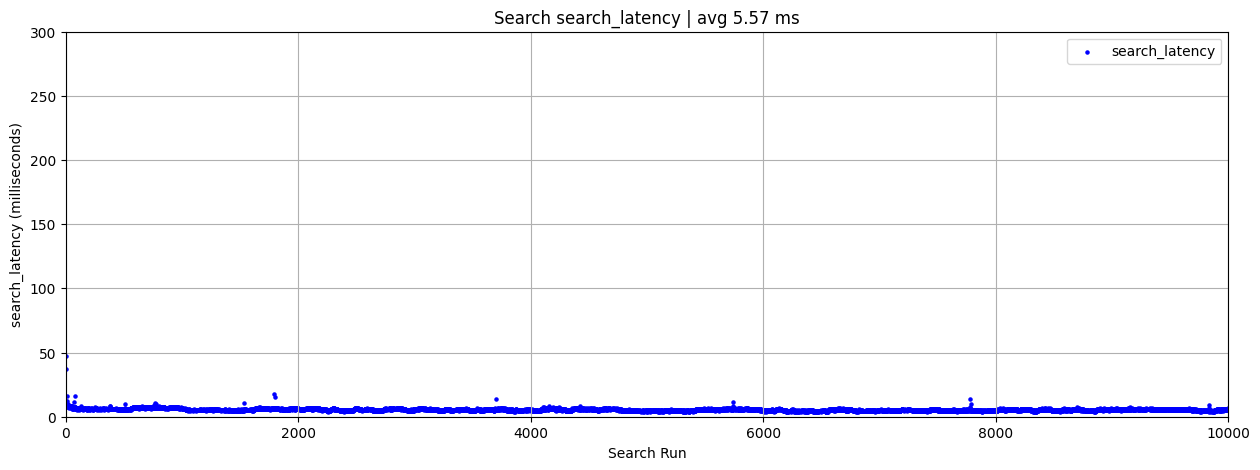

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "search_latency": [(lat*1000) for lat in search_latency]
})

avg_latency = sum([(lat*1000) for lat in search_latency]) / len(search_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['search_latency'], label="search_latency", color='blue', s=5)
plt.title(f"Search search_latency | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(X_TEST)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 300) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("search_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

In [8]:
# Parallelization for Ingest
import multiprocessing.pool
from tqdm.notebook import tqdm
import time
from opensearchpy.helpers import bulk

def ingest_data(client_number, vectors_to_be_ingested, start_id):
    print(f"Starting ingest for client {client_number} for vectors counts: {len(vectors_to_be_ingested)}")
    def dataGenLocal():
        for i, vec in enumerate(vectors_to_be_ingested):
            yield { "_index": vector_index_name, "_id": str(start_id + i), "vec": vec.tolist() }

    bulk_size = 1000
    data_to_ingest = []
    total_time_to_ingest = 0.
    ingest_latency = []
    for data in tqdm(dataGenLocal(), total=len(vectors_to_be_ingested)):
        if len(data_to_ingest) == bulk_size:
            start = time.time()
            (res, errors) = bulk(client, data_to_ingest)
            end = time.time()
            total_time_to_ingest += (end-start)
            ingest_latency.append(end-start)
            if len(errors) != 0:
                print(errors)
                data_to_ingest = []

                StopIteration
            else:
                data_to_ingest = []

        if len(data_to_ingest) < bulk_size:
            data_to_ingest.append(data)
        

    if len(data_to_ingest) != 0:
        start = time.time()
        (res, errors) = bulk(client, data_to_ingest)
        end = time.time()
        total_time_to_ingest += (end-start)
        if len(errors) != 0:
            print(errors)
        else:
            data_to_ingest = []
    return total_time_to_ingest, ingest_latency, errors
    
    

create_index(vector_index_name)

clients = 10 # change this to whatever value is suited for you

vectors_per_client = len(X_TRAIN)//clients

print(f"Total Vectors are: {len(X_TRAIN)}, vectors per client is : {vectors_per_client}")


vectors = []
batch = []
i = 0
print(f"Partioning the data...")
for vector in X_TRAIN:
    i = i + 1
    if len(batch) == vectors_per_client:
        vectors.append(batch)
        batch = []
    batch.append(vector)
# Put the last batch of vectors
vectors.append(batch)

mp_total_time_to_ingest = 0.
mp_ingest_latency = []
mp_errors = []
ctx = multiprocessing.get_context("fork")
with ctx.Pool(clients) as pool:
    ingest_arg_tuple = [(idx + 1, vectors[idx], idx * vectors_per_client) for idx in range(clients)]
    ingestion_response = list(pool.starmap(ingest_data, ingest_arg_tuple))
for future in ingestion_response:
    t_time_to_ingest, i_latency, errors = future
    mp_total_time_to_ingest += t_time_to_ingest
    mp_ingest_latency.extend(i_latency)
    mp_errors.extend(errors)

if len(mp_errors) !=0 :
    print(f"Errors happened while doing the ingest. {mp_errors}")
else:
    print(f"Total time to ingest documents are : {mp_total_time_to_ingest} for documents : {len(X_TEST)}")



Creating the index. Response : {'acknowledged': True, 'shards_acknowledged': True, 'index': 'test_vector'}
Total Vectors are: 1000000, vectors per client is : 100000
Partioning the data...
Starting ingest for client 1 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 2 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 3 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 4 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 5 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 6 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 7 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 8 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 9 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

Starting ingest for client 10 for vectors counts: 100000


  0%|          | 0/100000 [00:00<?, ?it/s]

ConnectionTimeout: ConnectionTimeout caused by - ReadTimeout(None: None)

In [ ]:
# Useful Metrics For Multi Processing Ingestion
print("========================== Ingest Metrics Multi Processing ===================================")

print("========================== Client side latency ===================================")
print(f"\n\naverage Latency(ms): {np.average(mp_ingest_latency) *1000} for bulksize: {bulk_size}") 
print(f"p50 Latency(ms): {np.percentile(mp_ingest_latency, 50) *1000} for bulksize: {bulk_size}") 
print(f"p90 Latency(ms): {np.percentile(mp_ingest_latency, 90) *1000} for bulksize: {bulk_size}")
print(f"p99 Latency(ms): {np.percentile(mp_ingest_latency, 99) *1000} for bulksize: {bulk_size}") 

========================== Ingest Metrics Multi Processing ===================================
========================== Client side latency ===================================


average Latency(ms): 918.0305715318437 for bulksize: 1000
p50 Latency(ms): 917.6836013793945 for bulksize: 1000
p90 Latency(ms): 950.5099296569824 for bulksize: 1000
p99 Latency(ms): 1101.3874292373657 for bulksize: 1000


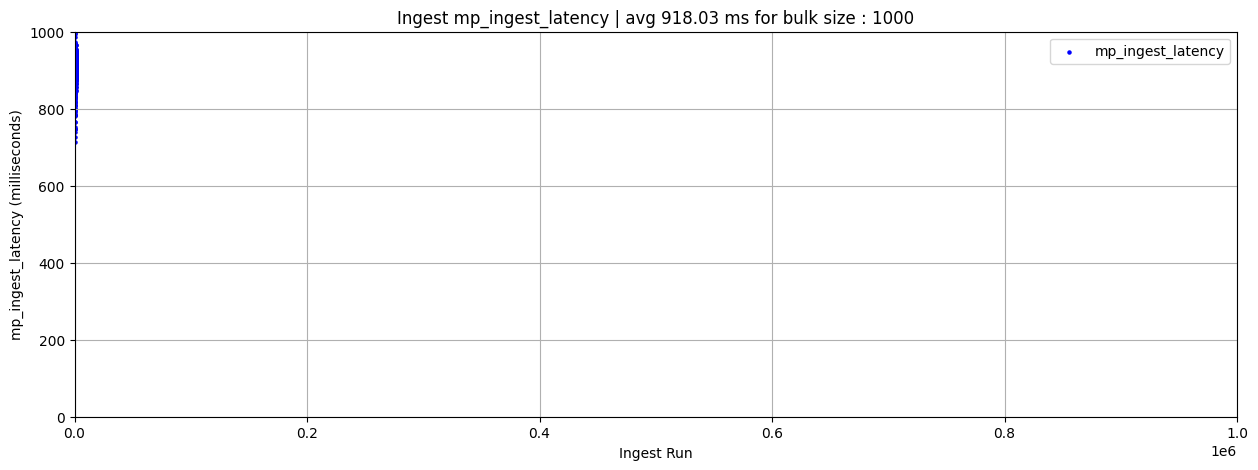

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "mp_ingest_latency": [(lat*1000) for lat in mp_ingest_latency]
})

avg_latency = sum([(lat*1000) for lat in mp_ingest_latency]) / len(mp_ingest_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['mp_ingest_latency'], label="mp_ingest_latency", color='blue', s=5)
plt.title(f"Ingest mp_ingest_latency | avg {avg_latency:.2f} ms for bulk size : {bulk_size}")
plt.xlabel("Ingest Run")
plt.xlim(0, len(X_TRAIN)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 1000) 
plt.ylabel("mp_ingest_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Parallelization for Search
import multiprocessing.pool
from tqdm.notebook import tqdm
import time

def run_search(client_number, query_list, k):
    neighbors_lists = []
    search_latency = []
    took_time = []
    print(f"client_number : {client_number}, query: {len(query_list)}")
    # Better to create client for each process so that no locking happens
    c = OpenSearch(
        hosts = [{'host': OS_HOST, 'port': OS_PORT}],
        http_compress = True, # enables gzip compression for request bodies
        http_auth = (OS_USER, OS_PASSWORD),
        use_ssl = False,
        verify_certs = True,
        connection_class = RequestsHttpConnection,
        timeout=6000,
        pool_maxsize = 20
    )
    # Doing an info call to make sure client is ready, this will avoid the latency for 1st connection
    c.info()
    
    for query in tqdm(query_list):
        query_body = {
            "size": k,
            "query": {
                "knn": {
                    "vec": {
                        "vector": query.tolist(),
                        "k": k
                    }
                }
            }
        }
        start = time.time()
        search_response = c.search(body=query_body, index=vector_index_name, _source=False, docvalue_fields=["_id"], stored_fields="_none_")
        end = time.time()
        search_latency.append(end - start)
        took_time.append(search_response["took"])
        search_hits = search_response['hits']['hits']
        search_neighbors = [int(hit["fields"]["_id"][0]) for hit in search_hits]
        neighbors_lists.append(search_neighbors)
    return search_latency, took_time, neighbors_lists, client_number
        

clients = 10

queries_per_client = len(X_TEST)//clients

print(f"Total Queries are: {len(X_TEST)}, queries per client is : {queries_per_client}")


queries = []
batch = []
i = 0
for query in X_TEST:
    i = i + 1
    if len(batch) == queries_per_client:
        queries.append(batch)
        batch = []
    batch.append(query)
# Put the last batch of queries
queries.append(batch)

mp_neighbors_lists = {}
mp_search_latency = []
mp_took_time = []
k = 10

ctx = multiprocessing.get_context("fork")
with ctx.Pool(clients) as pool:
    query_arg_tuple = [(idx + 1, queries[idx], k) for idx in range(clients)]
    queries_response = list(pool.starmap(run_search, query_arg_tuple))
for future in queries_response:
    s_lat, t_time, n_lists, client_number = future
    mp_search_latency.extend(s_lat)
    mp_neighbors_lists[client_number] = n_lists
    mp_took_time.extend(t_time)

print("Calculating Recall ...")
query_number:int = 0
recall:float = 0.
for client_number in tqdm(range(clients)):
    queries_response_list = mp_neighbors_lists[client_number + 1]
    for actual_neighbors in queries_response_list:
        expected_neighbors = X_NEIGHBORS[query_number][0:k]
        print(actual_neighbors, expected_neighbors)
        counter = 0.0
        query_number = query_number + 1
        for element in actual_neighbors:
            if element in expected_neighbors:
                counter = counter + 1
        recall = recall + (counter/k)

recall = recall / len(X_TEST)

print(f'Recall @k{k} is : {recall}')

Total Queries are: 10000, queries per client is : 1000


client_number : 1, query: 1000
client_number : 2, query: 1000
client_number : 3, query: 1000client_number : 4, query: 1000

client_number : 5, query: 1000
client_number : 6, query: 1000
client_number : 7, query: 1000
client_number : 8, query: 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

client_number : 9, query: 1000
client_number : 10, query: 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating Recall ...


  0%|          | 0/10 [00:00<?, ?it/s]

[] [932085 934876 561813 708177 706771 695756 435345 701258 455537 872728]
[] [413247 413071 706838 880592 249062 400194 942339 880462 987636 941776]
[] [669835 408764 408462 408855 551661 861882 406273 406324 551743 861530]
[] [970797 125539  48044 191115 889039 546470 123985 546496 207768 831905]
[] [340871 748397 748193 175336 716433 112586 107281 416604 371420 368246]
[] [187470  67875 220473 460733 896005  27746 943689 669622 947299 515025]
[] [402219 982379 652078 880346  59540 511412 595673 703786 982409 596714]
[] [906750 618842 807599 569178 107468 207868 476215 762217 762237   5447]
[] [376328 325865 323160 376277 323464 724549 176970 695175 803977 181435]
[] [178811 177646 181997 181605 821938 807785 716433 358802 803100 866737]
[] [316210 320547 992617 297239 753170 806980 432201 988918 807092 180642]
[] [  4697 762035 824256 672308 689860 824098 609725 609704 910776 923610]
[] [390776 563997 923810 931688 564008 191546  13183 564079 564042 224306]
[] [522078 134090 596084 

In [ ]:
# Useful Metrics For Multi Processing
print("========================== Search Metrics Multi Processing ===================================")
print("========================== Server Side Latency ===================================")
print(f"average took_time(ms): {np.average(mp_took_time)}") 
print(f"p50 took_time(ms): {np.percentile(mp_took_time, 50)}") 
print(f"p90 took_time(ms): {np.percentile(mp_took_time, 90)}")
print(f"p99 took_time(ms): {np.percentile(mp_took_time, 99)}")


print("========================== Client side latency ===================================")
print(f"\n\naverage Latency(ms): {np.average(mp_search_latency) *1000}") 
print(f"p50 Latency(ms): {np.percentile(mp_search_latency, 50) *1000}") 
print(f"p90 Latency(ms): {np.percentile(mp_search_latency, 90) *1000}")
print(f"p99 Latency(ms): {np.percentile(mp_search_latency, 99) *1000}")
   
print("========================== Recall Metrics===================================")
print(f'Recall @k{k} is : {recall}')

========================== Search Metrics Multi Processing ===================================
========================== Server Side Latency ===================================
average took_time(ms): 0.1093
p50 took_time(ms): 0.0
p90 took_time(ms): 0.0
p99 took_time(ms): 2.0
========================== Client side latency ===================================


average Latency(ms): 3.3152026176452636
p50 Latency(ms): 2.932310104370117
p90 Latency(ms): 4.802727699279785
p99 Latency(ms): 7.909264564514164
========================== Recall Metrics===================================
Recall @k10 is : 0.0


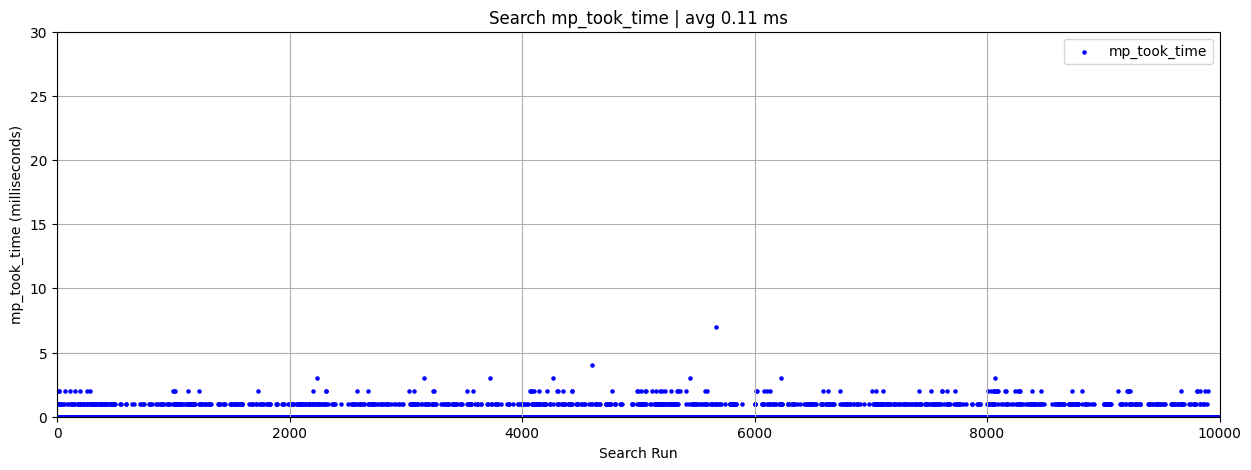

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "mp_took_time": mp_took_time
})

avg_latency = sum(mp_took_time) / len(mp_took_time)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['mp_took_time'], label="mp_took_time", color='blue', s=5)
plt.title(f"Search mp_took_time | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(X_TEST)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 30) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("mp_took_time (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

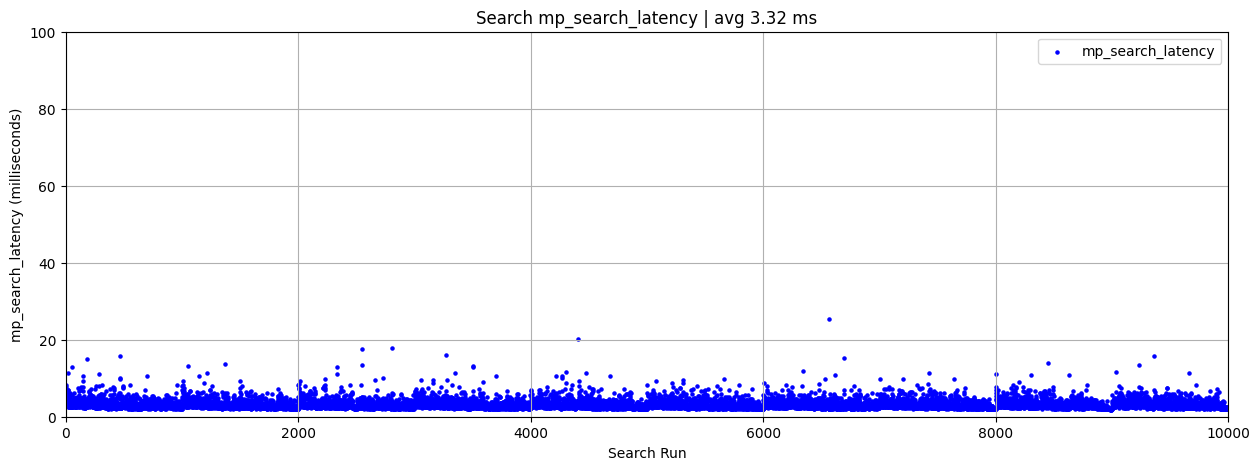

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "mp_search_latency": [(lat*1000) for lat in mp_search_latency]
})

avg_latency = sum([(lat*1000) for lat in mp_search_latency]) / len(mp_search_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['mp_search_latency'], label="mp_search_latency", color='blue', s=5)
plt.title(f"Search mp_search_latency | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(X_TEST)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 100) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("mp_search_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()